In [381]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("../../../../src/")
import nanonets
import nanonets_utils

import scienceplots
plt.style.use(["science","bright","grid"])
%matplotlib inline

# Global
N_PERIODS   = 40
AMPLITUDE   = 0.1
EPS_S       = 3.9
EPS_R       = 2.6

### 2 NP Device of equal NP-Size

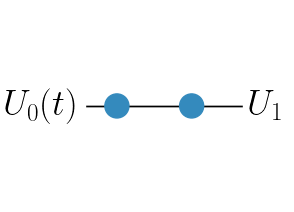

In [338]:
topo = {
    "Nx":               2,
    "Ny":               1,
    "Nz":               1,
    "e_pos":            [[0, 0, 0], [1, 0, 0]],
    "electrode_type":   ['constant', 'constant']
}
sim     = nanonets.simulation(topo)
fig,ax  = nanonets_utils.display_network(sim, provide_electrode_labels=['$U_0(t)$','$U_1$'], font_size=26)

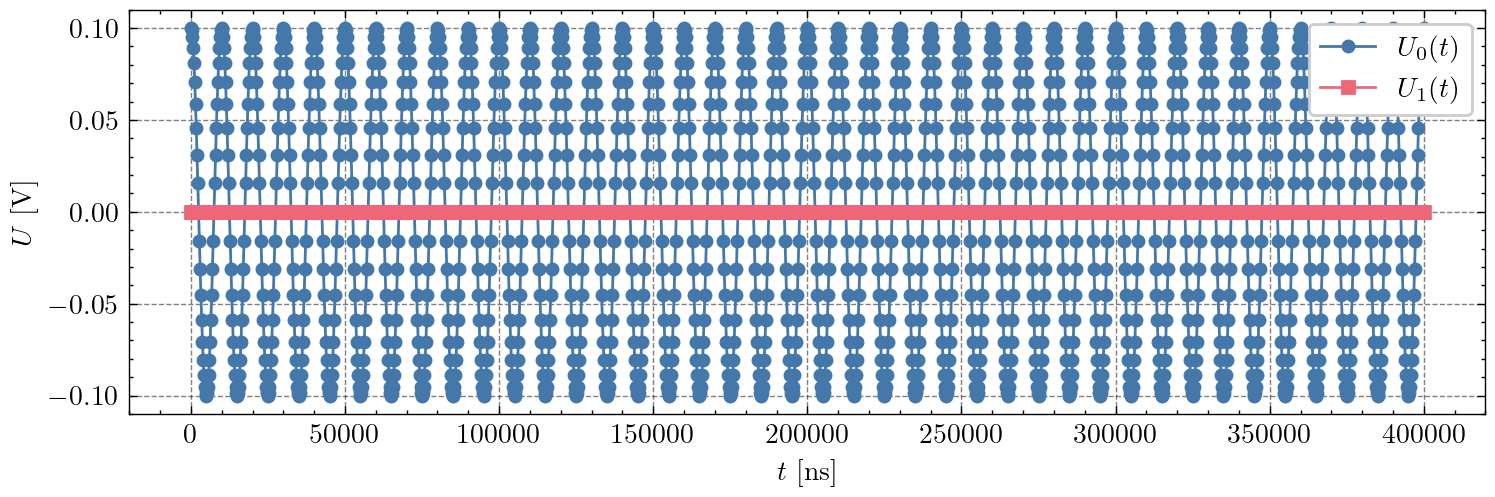

In [339]:
# Time
f_0     = 1e5
dt      = 1 / (40*f_0)
N       = int(np.ceil((N_PERIODS / f_0) / dt))
t       = np.arange(N)*dt

# Volt
U_0     = AMPLITUDE*np.cos(2*np.pi*f_0*t)
U_1     = np.repeat(0,N)
U       = np.zeros(shape=(N,3))
U[:,0]  = U_0
U[:,1]  = U_1

fig,ax = plt.subplots(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2.5)
ax.plot(t*1e9, U_0, '-o', label='$U_0(t)$', ms=4)
ax.plot(t*1e9, U_1, '-s', label='$U_1(t)$', ms=4)
ax.set_ylabel("$U$ [V]")
ax.set_xlabel("$t$ [ns]")
ax.legend()

In [340]:
# Simulation
sim.run_var_voltages(voltages=U, time_steps=t, target_electrode=1, T_val=5.0, save=False, stat_size=20)

In [341]:
# Results
results = pd.DataFrame(sim.return_output_values()[:,1:], columns=['steps','I','u_I'])
pots    = pd.DataFrame(sim.return_potential_landscape())
a, b    = sim.return_network_currents()
currs   = pd.DataFrame(b, columns=a)

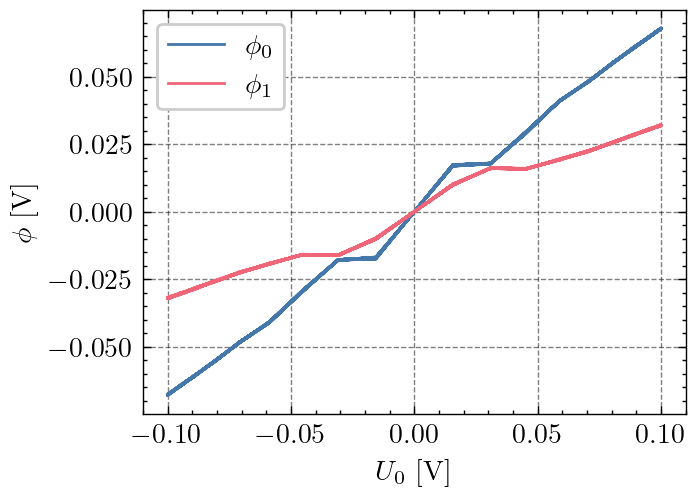

In [342]:
fig,ax = plt.subplots(dpi=200)
ax.plot(pots.iloc[:,0],pots.iloc[:,2], label='$\phi_0$')
ax.plot(pots.iloc[:,0],pots.iloc[:,3], label='$\phi_1$')
ax.set_xlabel('$U_0$ [V]')
ax.set_ylabel('$\phi$ [V]')
ax.legend()

Text(0.5, 0, '$t$ [ns]')

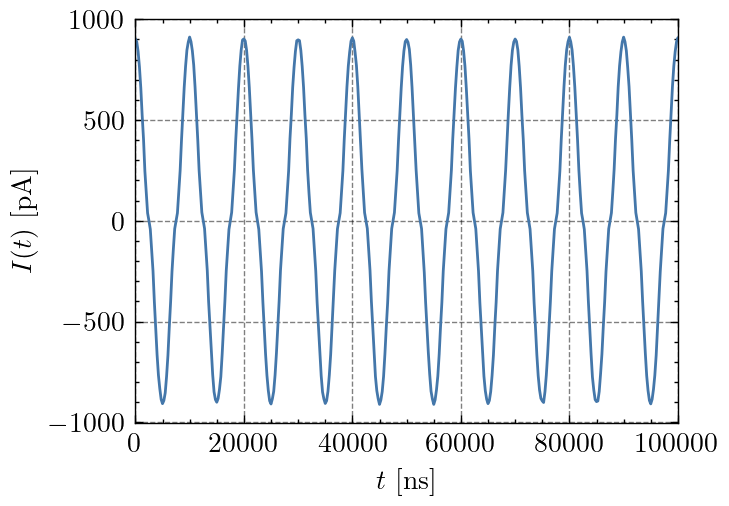

In [343]:
fig,ax = plt.subplots(dpi=200)
ax.plot(t[:-1]*1e9, results['I'])
ax.set_xlim(0,1e5)
ax.set_ylabel('$I(t)$ [pA]')
ax.set_xlabel('$t$ [ns]')

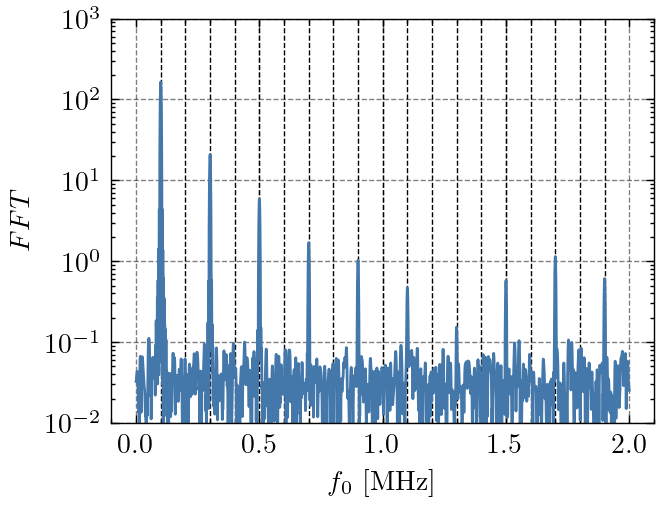

In [344]:
signal  = results['I'].values
xf, yf  = nanonets_utils.fft(signal=signal, dt=dt, n_padded=len(signal)*5, use_hann=True)

fig,ax = plt.subplots(dpi=200)
ax.plot(xf/1e6, yf)
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_ylim(1e-2,1e3)
ax.set_yscale('log')
ax.vlines([i*f_0/1e6 for i in range(1,20)], 1e-2, 1e3, colors='black', linestyles='--', zorder=0.1, lw=0.5)

Text(0.5, 0, '$|I|$')

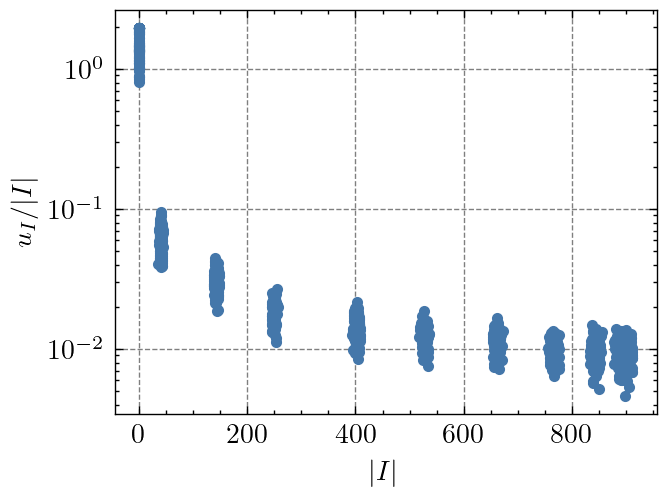

In [345]:
fig,ax  = plt.subplots(dpi=200)
ax.plot(results['I'].abs(),results['u_I']/results['I'].abs(),'.')
ax.set_yscale('log')
ax.set_ylabel('$u_I/|I|$')
ax.set_xlabel('$|I|$')

In [346]:
# FFT
ffts = []
for i in range(4):
    signal  = pots.iloc[:,i]
    xf, yf  = nanonets_utils.fft(signal=signal, dt=dt, n_padded=len(signal)*5, use_hann=True)
    ffts.append(yf)
ffts = pd.DataFrame(np.array(ffts).T)

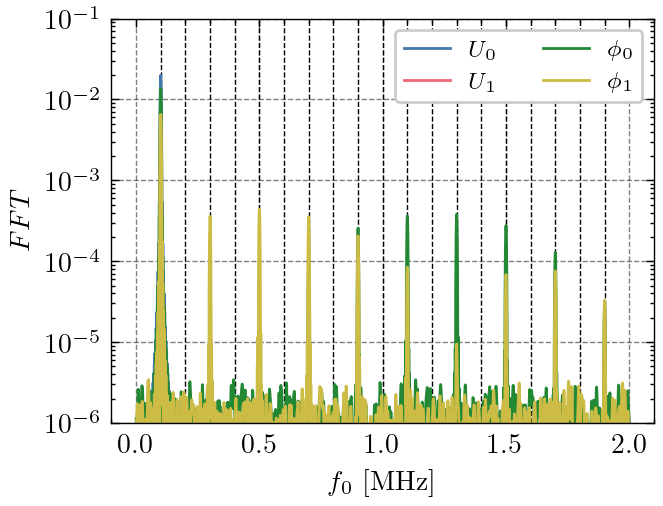

In [347]:
l       = ['$U_0$','$U_1$','$\phi_0$','$\phi_1$']
fig,ax  = plt.subplots(dpi=200)
for i in range(0,4):
    ax.plot(xf/1e6, ffts.iloc[:,i], label=l[i])
ax.set_yscale('log')
ax.legend(ncol=2, fontsize='small', loc='upper right')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_ylim(1e-6,1e-1)
ax.vlines([i*f_0/1e6 for i in range(1,20)], 1e-6, 1e-1, colors='black', linestyles='--', zorder=0.1, lw=0.5)

### Temperature dependency

In [ ]:
def mutal_capacitance_adjacent_spheres(self, eps_r: float, np_radius1: float, np_radius2: float, np_distance: float) -> float:
       
    # Base factor
    d       = np_radius1 + np_radius2 + np_distance
    factor  = 4 * self.PI * self.EPSILON_0 * eps_r * (np_radius1 * np_radius2) / d
    
    # Terms of the Taylor expansion
    term1       = 1.0
    term2       = (np_radius1 * np_radius2) / (d**2 - 2*np_radius1*np_radius2)
    denominator = d**4 - 4*(d**2)*np_radius1*np_radius2 + 3*(np_radius1**2)*(np_radius2**2)
    term3       = ((np_radius1**2)*(np_radius2**2)) / denominator
    cap         = factor * (term1 + term2 + term3)
                
    return cap

def self_capacitance_sphere(self, eps_s: float, np_radius: float) -> float:
    
    factor = 4 * self.PI * self.EPSILON_0 * eps_s
    cap = factor * np_radius

    return cap
    

In [379]:
def C_s(r):
    factor  = 4 * np.pi * 8.85418781762039e-3 * EPS_S
    cap     = factor * r
    return cap
def C_m(r1,r2):
    # Base factor
    d       = r1 + r2 + 1.0
    factor  = 4 * np.pi * 8.85418781762039e-3 * EPS_R * (r1 * r2) / d
    
    # Terms of the Taylor expansion
    term1       = 1.0
    term2       = (r1 * r2) / (d**2 - 2*r1*r2)
    denominator = d**4 - 4*(d**2)*r1*r2 + 3*(r1**2)*(r2**2)
    term3       = ((r1**2)*(r2**2)) / denominator
    cap         = factor * (term1 + term2 + term3)
                
    return cap

In [ ]:
r1,r2   = 10.0, 10.0
D       = (C_m(r1,r2)+C_m(r1,r2)+C_s(r1))*(C_m(r1,r2)+C_m(r1,r2)+C_s(r1))-C_m(r1,r2)**2
alpha   = C_m(r1,r2)*(C_m(r1,r2)+C_m(r1,r2)+C_s(r1))/D
beta    = C_m(r1,r2)*C_m(r1,r2)/D

In [398]:
C_s(r1)

4.339335218609111

In [397]:
C_m(r1,r2)

2.235680775954707

In [382]:
T_vals  = np.linspace(1,298,1000)
A_S1    = sim.const_capacitance_values[0]
A_12    = sim.const_capacitance_values[3]
A_2D    = sim.const_capacitance_values[4]
kBT     = sim.kb*T_vals

In [395]:
amps    = 0.1
B_1S    = sim.ele_charge*(alpha-1)*amps
B_12    = sim.ele_charge*(alpha-beta)*amps
B_2D    = sim.ele_charge*beta*amps

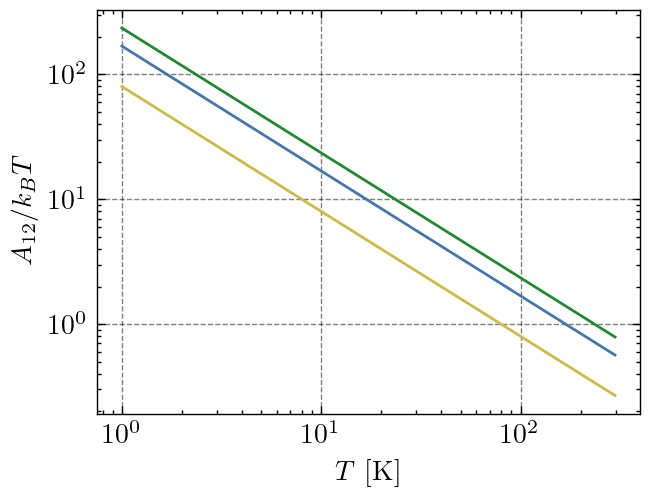

In [396]:
fig, ax = plt.subplots(dpi=200)
ax.plot(T_vals,A_12/kBT)
ax.plot(T_vals,B_1S/kBT)
ax.plot(T_vals,B_12/kBT)
ax.plot(T_vals,B_2D/kBT)
ax.set_xlabel("$T$ [K]")
ax.set_ylabel("$A_{12}/k_BT$")
ax.set_yscale('log')
ax.set_xscale('log')

### 2 NP Device of unequal NP-Size

In [319]:
np2     = {'np_index': [1],
        'mean_radius': 1e7,
        'std_radius': 0.0}
sim2    = nanonets.simulation(topo, np_info2=np2)

In [320]:
# Simulation
sim2.run_var_voltages(voltages=U, time_steps=t, target_electrode=1, T_val=5.0, save=False, stat_size=20)

In [327]:
# Results
results2 = pd.DataFrame(sim2.return_output_values()[:,1:], columns=['steps','I','u_I'])
pots2    = pd.DataFrame(sim2.return_potential_landscape())
a, b     = sim2.return_network_currents()
currs2   = pd.DataFrame(b, columns=a)

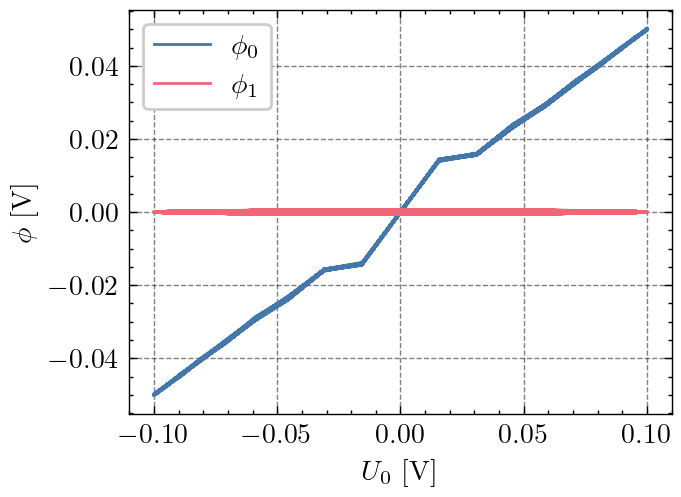

In [328]:
fig,ax = plt.subplots(dpi=200)
ax.plot(pots2.iloc[:,0],pots2.iloc[:,2], label='$\phi_0$')
ax.plot(pots2.iloc[:,0],pots2.iloc[:,3], label='$\phi_1$')
ax.set_xlabel('$U_0$ [V]')
ax.set_ylabel('$\phi$ [V]')
ax.legend()

Text(0.5, 0, '$t$ [ns]')

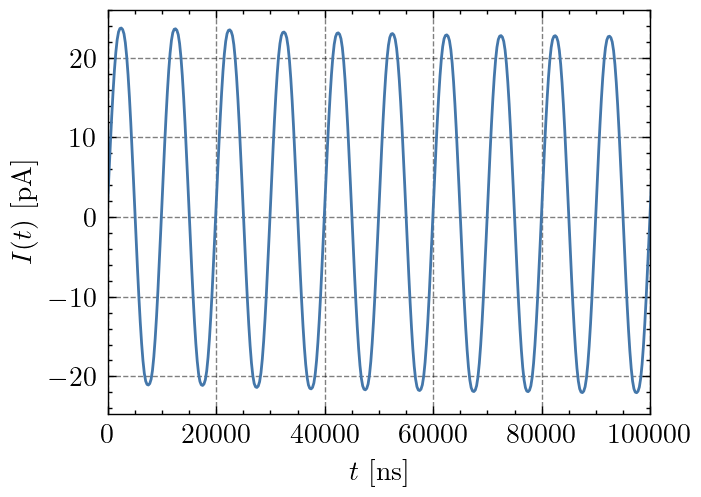

In [329]:
fig,ax = plt.subplots(dpi=200)
ax.plot(t[:-1]*1e9, results2['I'])
ax.set_xlim(0,1e5)
ax.set_ylabel('$I(t)$ [pA]')
ax.set_xlabel('$t$ [ns]')

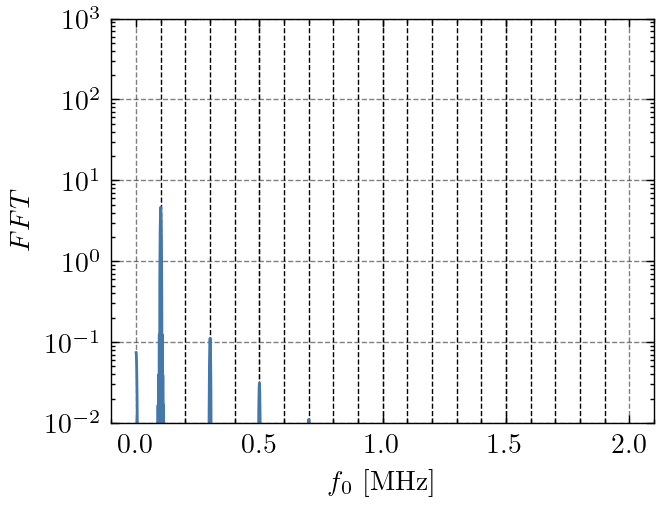

In [333]:
signal  = results2['I'].values
xf, yf  = nanonets_utils.fft(signal=signal, dt=dt, n_padded=len(signal)*5, use_hann=True)

fig,ax = plt.subplots(dpi=200)
ax.plot(xf/1e6, yf)
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_ylim(1e-2,1e3)
ax.set_yscale('log')
ax.vlines([i*f_0/1e6 for i in range(1,20)], 1e-2, 1e3, colors='black', linestyles='--', zorder=0.1, lw=0.5)

Text(0.5, 0, '$|I|$')

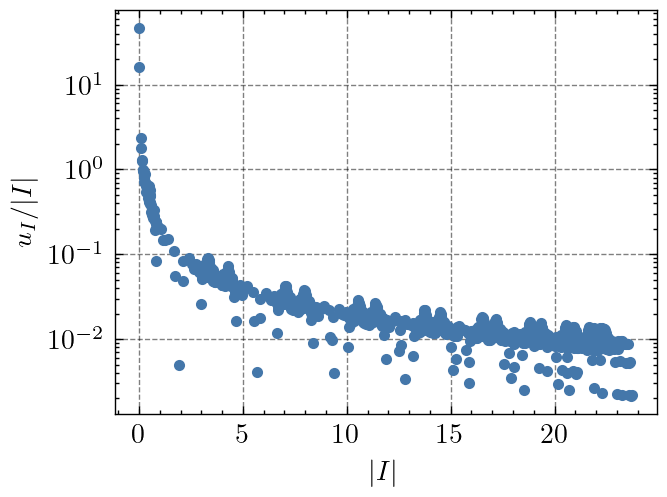

In [334]:
fig,ax  = plt.subplots(dpi=200)
ax.plot(results2['I'].abs(),results2['u_I']/results2['I'].abs(),'.')
ax.set_yscale('log')
ax.set_ylabel('$u_I/|I|$')
ax.set_xlabel('$|I|$')

In [335]:
# FFT
ffts = []
for i in range(4):
    signal  = pots2.iloc[:,i]
    xf, yf  = nanonets_utils.fft(signal=signal, dt=dt, n_padded=len(signal)*5, use_hann=True)
    ffts.append(yf)
ffts = pd.DataFrame(np.array(ffts).T)

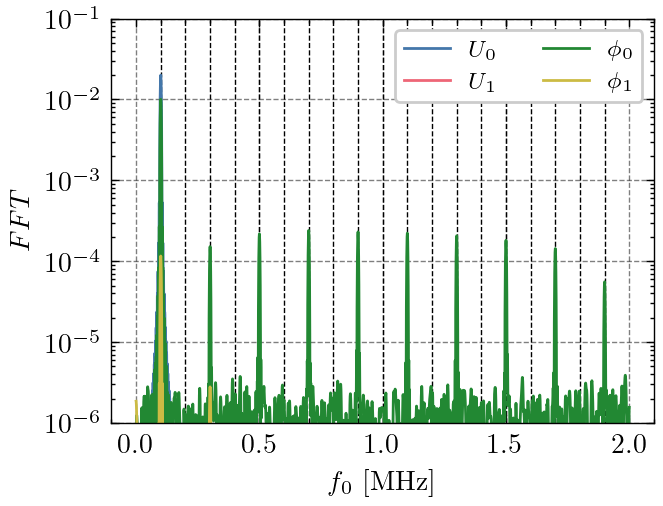

In [336]:
l       = ['$U_0$','$U_1$','$\phi_0$','$\phi_1$']
fig,ax  = plt.subplots(dpi=200)
for i in range(0,4):
    ax.plot(xf/1e6, ffts.iloc[:,i], label=l[i])
ax.set_yscale('log')
ax.legend(ncol=2, fontsize='small', loc='upper right')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_ylim(1e-6,1e-1)
ax.vlines([i*f_0/1e6 for i in range(1,20)], 1e-6, 1e-1, colors='black', linestyles='--', zorder=0.1, lw=0.5)